In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import gc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

In [ ]:
seed = 42

In [ ]:
# This is for selecting certain molecular descriptors from RDKIT library
descr = Descriptors._descList[0:2] + Descriptors._descList[3:]
calc = [x[1] for x in descr]

In [ ]:
# getting mols/RDkit objects
def fingerprint(smiles):
        i=0
        fps_list = []
        chunksize = smiles.shape[0] // 381

        for chunk in np.array_split(smiles, chunksize):
            mols = [Chem.MolFromSmiles(s) for s in chunk]
            del chunk
            fps = np.array(describe(mols))

            fps_list.append(fps)

        fps_train = np.concatenate(fps_list, axis=0)
        return fps_train

In [ ]:
# getting molecular fingerprints and descriptors
def describe(mols):
    descrs = []
    for mol in mols:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        fp_list = [int(x) for x in fp.ToBitString()]

        ds_n = [float(np.finfo(np.float32).max if v(mol) > np.finfo(np.float32).max else np.float32(v(mol))) for v in calc]
        descrs.append(fp_list + ds_n)

    return descrs

## ***Loading data***

In [ ]:
train = pd.read_excel('Train_with_smiles.xlsx')
valid = pd.read_excel('Valid_with_smiles.xlsx')
test = pd.read_excel('Test_with_smiles.xlsx')

data = pd.concat([train, test, valid], ignore_index=True)

cols = ['PUBCHEM_ACTIVITY_OUTCOME', 'smiles']
data = data[cols]
data = data.rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': 'labels'})

label_map = {
    'Active': -1,
    'Inactive': 1,
}

data['labels'] = data['labels'].map(label_map)

In [ ]:
del train
del valid
del test
gc.collect()

41022

In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

In [ ]:
train_df1, smaller_train_df1 = train_test_split(train_df1, test_size=0.01, random_state = seed, stratify=train_df1['labels'])

<AxesSubplot:>

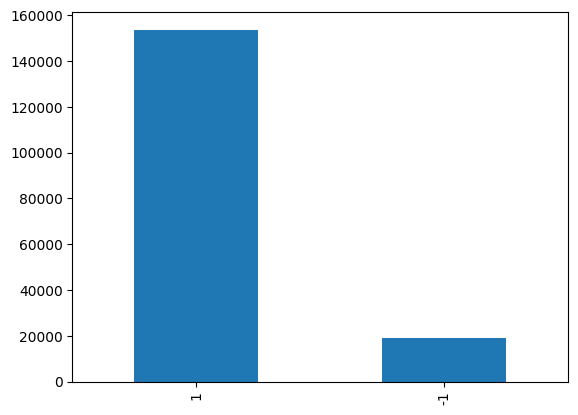

In [ ]:
train_df1['labels'].value_counts().plot.bar()

In [ ]:
train_df1['labels'].value_counts()

 1    153728
-1     18997
Name: labels, dtype: int64

## ***Getting molecular descripters and fingerprints***

In [ ]:
smiles = smaller_train_df1['smiles']
y = smaller_train_df1['labels'].reset_index()

In [ ]:
fps_train = fingerprint(smiles)

In [ ]:
x = pd.DataFrame(fps_train)

In [ ]:
nan = np.where(np.asanyarray(np.isnan(x)))
nan_id = nan[0]
nan_id_unique = np.unique(nan_id)
nan_list = nan_id_unique.tolist()

y = y.drop(nan_list)
y = y.drop('index', axis = 1)
x = x.dropna()

In [ ]:
y_series = y['labels'].ravel()
y_series.shape

(1744,)

## ***Hyper-parameter Fine-tuning***

In [ ]:
def scorer_f(estimator, x_in, y_in):
    y_pred = estimator.predict(x_in)
    return f1_score(y_in, y_pred, average='weighted', labels=[1, -1])

In [ ]:
clf = IsolationForest(random_state=seed, n_jobs=-1, n_estimators = 1000)

param_grid = {'contamination': [0.1, 0.01, 0.001],
              'max_samples': [0.1, 0.5, 1],
              'bootstrap': [True, False]}

grid_estimator = GridSearchCV(                clf,
                                              param_grid,
                                              scoring=scorer_f,
                                              cv=3,
                                              n_jobs=-1,
                                              return_train_score=True,
                                              error_score='raise'
                             )

grid_estimator.fit(x, y_series)

GridSearchCV(cv=3, error_score='raise',
             estimator=IsolationForest(n_estimators=1000, n_jobs=-1,
                                       random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.1, 0.01, 0.001],
                         'max_samples': [0.1, 0.5, 1]},
             return_train_score=True,
             scoring=<function scorer_f at 0x15511414b640>)

In [ ]:
best_model = grid_estimator.best_estimator_

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_estimator.best_params_)

Best Hyperparameters: {'bootstrap': False, 'contamination': 0.1, 'max_samples': 0.5}


## Test evaluation

In [ ]:
smiles = test_df1['smiles']
y = test_df1['labels'].reset_index()

In [ ]:
fps_test = fingerprint(smiles)

In [ ]:
x = pd.DataFrame(fps_test)

nan = np.where(np.asanyarray(np.isnan(x)))
nan_id = nan[0]
nan_id_unique = np.unique(nan_id)
nan_list = nan_id_unique.tolist()

y = y.drop(nan_list)
y = y.drop('index', axis = 1)
x = x.dropna()

In [ ]:
preds = best_model.predict(x)

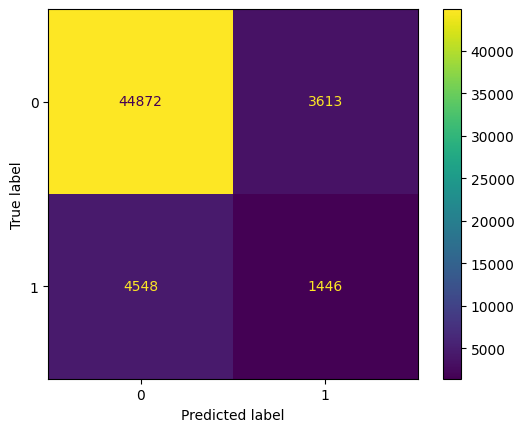

In [ ]:
cm = confusion_matrix(y, preds, labels =[1, -1])
ConfusionMatrixDisplay(cm).plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.24124124124124124
spe:0.9254821078684129
CCR:0.5833616745548271
ppv:0.28582723858470055
nen:0.9079724807770133


## Ten runs:

In [ ]:
clf = IsolationForest(n_jobs=-1, bootstrap=False, contamination=0.1, max_samples =0.5 , n_estimators =500)

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        valid_df1 = valid_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)


        # train on smaller portion of the data
        train_df1, smaller_train_df1 = train_test_split(train_df1, test_size=0.01, random_state = seed, stratify=train_df1['labels'])

        # preparing data for training
        smiles = smaller_train_df1['smiles']
        y = smaller_train_df1['labels'].reset_index()
        fps_train = fingerprint(smiles)

        x = pd.DataFrame(fps_train)
        x = x.dropna()

        # fit the model
        clf.random_state=seed
        clf.fit(x)

        # prepare evaluation dataevaluation
        smiles = test_df1['smiles']
        y = test_df1['labels'].reset_index()
        fps_test = fingerprint(smiles)

        x = pd.DataFrame(fps_test)

        nan = np.where(np.asanyarray(np.isnan(x)))
        nan_id = nan[0]
        nan_id_unique = np.unique(nan_id)
        nan_list = nan_id_unique.tolist()

        y = y.drop(nan_list)
        y = y.drop('index', axis = 1)
        x = x.dropna()

        #predict and evaluate
        preds = clf.predict(x)

        cm = confusion_matrix(y, preds,labels =[1, -1])
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp))
        npv = (tn / (tn + fn))


        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)

        print('finished run:', len(ccr_list))

  return ccr_list, sen_list, spe_list, ppv_list, npv_list

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list = runs(random_seed_list, data)

[13:58:49] WARNING: not removing hydrogen atom without neighbors
[13:58:49] WARNING: not removing hydrogen atom without neighbors
[13:58:49] WARNING: not removing hydrogen atom without neighbors
[13:58:49] WARNING: not removing hydrogen atom without neighbors
[13:58:49] WARNING: not removing hydrogen atom without neighbors
[13:58:53] WARNING: not removing hydrogen atom without neighbors
[13:58:53] WARNING: not removing hydrogen atom without neighbors
[13:58:53] WARNING: not removing hydrogen atom without neighbors


finished run: 1


[14:11:59] WARNING: not removing hydrogen atom without neighbors
[14:12:01] WARNING: not removing hydrogen atom without neighbors
[14:12:01] WARNING: not removing hydrogen atom without neighbors
[14:12:01] WARNING: not removing hydrogen atom without neighbors
[14:20:39] WARNING: not removing hydrogen atom without neighbors
[14:20:46] WARNING: not removing hydrogen atom without neighbors
[14:20:46] WARNING: not removing hydrogen atom without neighbors
[14:20:46] WARNING: not removing hydrogen atom without neighbors


finished run: 2


[14:34:12] WARNING: not removing hydrogen atom without neighbors
[14:34:17] WARNING: not removing hydrogen atom without neighbors
[14:34:17] WARNING: not removing hydrogen atom without neighbors
[14:34:17] WARNING: not removing hydrogen atom without neighbors


finished run: 3
finished run: 4
finished run: 5
finished run: 6


[16:17:56] WARNING: not removing hydrogen atom without neighbors
[16:18:00] WARNING: not removing hydrogen atom without neighbors
[16:18:00] WARNING: not removing hydrogen atom without neighbors
[16:18:00] WARNING: not removing hydrogen atom without neighbors


finished run: 7
finished run: 8
finished run: 9
finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)


# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')

Mean and Standard Deviation of CCR: 0.58 ± 0.00
Mean and Standard Deviation of Sensitivity: 0.22 ± 0.01
Mean and Standard Deviation of Specificity: 0.93 ± 0.01
Mean and Standard Deviation of PPV: 0.29 ± 0.01
Mean and Standard Deviation of NPV: 0.91 ± 0.00
